<a href="https://colab.research.google.com/github/sugiyama404/forecast_sp500/blob/main/cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM,GRU
from keras.layers import Conv1D

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from google.colab import drive
import time

In [2]:
drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/reinforcement_learning/'
nov_train = '/content/drive/My Drive/' + nov_dir + 'sp500_train.csv'
nov_test = '/content/drive/My Drive/' + nov_dir + 'sp500_test.csv'

df = pd.read_csv(nov_train)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df['SP500'] = preprocessing.scale(df['SP500'])

print(df.shape)

maxlen = 10
n_sample = len(df) - maxlen
X, Y = [], []
for i in range(len(df) - maxlen):
    X.append(df[['SP500']].iloc[i:(i+maxlen)].values)
    Y.append(df[['SP500']].iloc[i+maxlen].values)
X_train=np.array(X)
y_train=np.array(Y)

print(X_train.shape)
print(y_train.shape)


df_test = pd.read_csv(nov_test)
df_test['Date'] = pd.to_datetime(df_test['Date'], format = '%Y-%m-%d')
df_test['SP500'] = preprocessing.scale(df_test['SP500'])

print(df_test.shape)

maxlen = 10
n_sample = len(df_test) - maxlen
X, Y = [], []
for i in range(len(df_test) - maxlen):
    X.append(df_test[['SP500']].iloc[i:(i+maxlen)].values)
    Y.append(df_test[['SP500']].iloc[i+maxlen].values)
X_test=np.array(X)
y_test=np.array(Y)

print(X_test.shape)
print(X_test.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(628, 2)
(618, 10, 1)
(618, 1)
(882, 2)
(872, 10, 1)
(872, 10, 1)


# ストップウォッチ関数

In [3]:
def stopwatch(end_time,start_time):
  elapsed_time = int(end_time - start_time)

  elapsed_hour = elapsed_time // 3600
  elapsed_minute = (elapsed_time % 3600) // 60
  elapsed_second = (elapsed_time % 3600 % 60)

  mozi = str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2)
  return mozi

# モデル構築

In [4]:
# maxlen = 10
n_in = 1
n_mid = 20
n_out = 1
batch_size = 8
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model = Sequential()

model.add(Conv1D(filters=n_in, kernel_size=3,strides=1, padding="same",activation="relu",batch_input_shape=(None, maxlen, n_in)))
model.add(LSTM(n_in, return_sequences=False))
model.add(Dense(1, kernel_initializer='random_uniform'))

'''
model.add(LSTM(n_mid,batch_input_shape=(None, maxlen, n_in),return_sequences=False))
model.add(Dense(n_in, kernel_initializer='random_uniform'))
'''
model.add(Activation("linear"))
model.compile(loss = "mean_squared_error", optimizer=opt)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 1)             4         
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 12        
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# 学習

In [5]:
epochs = 100

start_time = time.time()
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=0)
print("学習時間 LSTM : ", stopwatch(time.time(),start_time))

学習時間 LSTM :  00:01:15


# 損失関数

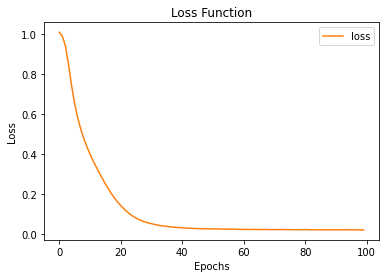

In [6]:
nov_dir2 = 'Colab Notebooks/workspace/export/'

loss = hist.history['loss']
epochs = len(loss)

plt.plot(range(epochs), loss, label="loss", color='tab:orange')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
nov_path2 = '/content/drive/My Drive/' + nov_dir2 + 'cnn_lstm_lossfunc.png'

plt.savefig(nov_path2)
plt.show()
plt.close('all')

# 訓練結果

<Figure size 432x288 with 0 Axes>

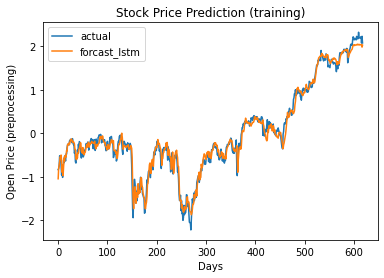

<Figure size 432x288 with 0 Axes>

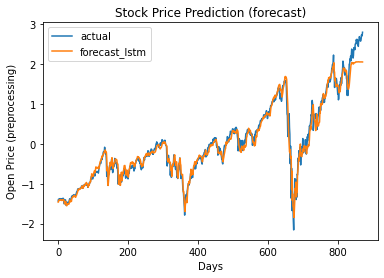

In [7]:
predicted = model.predict(X_train)
result = pd.DataFrame(predicted)
result.columns = ['forcast_lstm']
result['actual'] = y_train
result = result.reindex(columns=['actual', 'forcast_lstm'])

plt.figure()
result.plot()
plt.title('Stock Price Prediction (training)')
plt.xlabel('Days')
plt.ylabel('Open Price (preprocessing)')


nov_path3 = '/content/drive/My Drive/' + nov_dir2 + 'cnn_lstm_training.png'
plt.savefig(nov_path3)
plt.show()
plt.close('all')


predicted = model.predict(X_test)
result = pd.DataFrame(predicted)
result.columns = ['forecast_lstm']
result['actual'] = y_test
result = result.reindex(columns=['actual', 'forecast_lstm'])

plt.figure()
result.plot()
plt.title('Stock Price Prediction (forecast)')
plt.xlabel('Days')
plt.ylabel('Open Price (preprocessing)')

nov_path4 = '/content/drive/My Drive/' + nov_dir2 + 'cnn_lstm_forecast.png'
plt.savefig(nov_path4)
plt.show()
plt.close('all')